In [ ]:
# VA Note : from this notebook location, data is located
#           in /data/train, /data/valid, /data/test (plus copied samples in /extra)

In [2]:
import numpy as np

import cv2                

import matplotlib.pyplot as plt                        
%matplotlib inline   

In [43]:
import os

import torch
from torchvision import datasets

# VA added: 
import torchvision.transforms as transforms
import torchvision
#from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import WeightedRandomSampler

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
rootDataDir = 'data' # on local repo
trainDataPath = os.path.join(rootDataDir, 'train/')
validDataPath = os.path.join(rootDataDir, 'valid/')
testDataPath = os.path.join(rootDataDir, 'test/')

#imgResize = 256
#imgSize = 224
imgResize = 136
imgSize = 128 # let's  start small, use 128x128 images
train_transform = transforms.Compose([
                        #transforms.Resize((imgSize, imgSize)),
                        transforms.Resize(imgResize),
                        #transforms.RandomResizedCrop(size=(imgSize, imgSize)),
                        #transforms.RandomResizedCrop(size=(imgSize, imgSize), scale=(0.08, 0.60), ratio=(0.75, 1.333333), interpolation=2),
                        transforms.RandomHorizontalFlip(), # augmentation : randomly flip...
                        transforms.RandomRotation(10),  #  ...and random rotate
                        transforms.CenterCrop(imgSize), # 
                        #transforms.RandomResizedCrop(size=(imgSize, imgSize)),
                        transforms.ToTensor(),
                        #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                        transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
                        ]) # last for color rectif. (JPG img)
basic_transform = transforms.Compose([
                        transforms.Resize(imgResize),
                        transforms.CenterCrop(imgSize), 
                        #transforms.Resize((imgSize, imgSize)),
                        transforms.ToTensor(),
                        #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                        transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
                        ])
# above should provide a normalized, 3 color-planes, 128 px image
    
train_data = torchvision.datasets.ImageFolder(trainDataPath, transform=train_transform)
valid_data = torchvision.datasets.ImageFolder(validDataPath, transform=basic_transform)
# for final model eval :
test_data = torchvision.datasets.ImageFolder(testDataPath, transform=basic_transform)

# show loaded data infos :
print("total TRAIN images :{}".format(len(train_data)))
print("total VALID images :{}".format(len(valid_data)))
print("total TEST  images :{}".format(len(test_data)))

print("number of classes in TRAIN data : {}".format(len(train_data.classes)))

''' # NOT USED finally , as WEIGHT BASED SAMPLING seems to have NO EFFECT !!:
# takes as input a Train/valid data loaded above (train_data or valid_data)
# and returns the indiv. samples weight array to fix the unbalanced data set
# by using sample drawn using a WeightedRandomSampler
def getDataSampleWeight(dataSet):
    # step 1: get classes occurences (for that dataset)
    classOccurences = np.zeros(len(dataSet.classes))
    for idx in range(len(dataSet)):
        (sample,target) = dataSet.__getitem__(idx)
        #print("s_type:{} t_type:{}".format(type(sample), type(target) ))
        classOccurences[target] +=1 
    classWeights =  1.0 / (classOccurences +1.0) # len(train_data) / trainClassOccur
    # step 2: get indiv. sample weight array, using above computed info
    dataSamplesWeights = np.zeros(len(dataSet))
    for idx in range(len(dataSet)):
        (sample,target) = dataSet.__getitem__(idx)
        dataSamplesWeights[idx] = classWeights[target]
    return classOccurences, classWeights, dataSamplesWeights   

# VA NOTE : classes distribution is not equal (more image in some train img folders)
# so try using weight assisted training sample pick

trainClassOccurences, trainClassWeights, trainDataSamplesWeights = getDataSampleWeight(train_data)

print("classes' label occurences (for TRAIN data) :\n{}".format(trainClassOccurences[:]))
print("classes' adjusted weights (for TRAIN data) :\n{}".format(trainClassWeights[:]))
#print("First 20 TRAIN indiv. sample's weight :\n{}".format(trainDataSamplesWeights[:20]))

#validClassOccurences, validDataSamplesWeights = getDataSampleWeight(valid_data)
#print("First 20 classes' label occurence (for VALID data) :\n{}".format(validClassOccurences[:20]))
#print("First 20 VALID indiv. sample's weight :\n{}".format(validDataSamplesWeights[:20]))

# NOT USED finally :
# caution :  below must be provided indiv. sample weights, NOT the sample's CLASS weight
# torch.utils.data.WeightedRandomSampler(weights, num_samples, replacement=True)
train_wrSampler = torch.utils.data.WeightedRandomSampler(torch.tensor(trainDataSamplesWeights), len(train_data)) #  replacement=False)
#valid_wrSampler = torch.utils.data.WeightedRandomSampler(validDataSamplesWeights, len(valid_data), replacement=False)
'''

# define dataloader parameters
batch_size = 20
num_workers=0

### using both a Data Sampler AND the SHUFFLE option in DataLoader triggers
#      error 'sampler option is mutually exclusive with shuffle', 
#      so use one or the other (The sampler option i prepared is for unbalanced datasets)

# prepare data loaders :
# Note 1 : USING a SAMPLER is NOT COMPATIBLE with SHUFFLE option
# Note 2 : SHUFFLE should be used on TRAINing data only
'''
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, sampler=train_wrSampler, shuffle=False)
#valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
#                                          num_workers=num_workers, sampler=valid_wrSampler, shuffle=False)
'''
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)  # SHUFFLE for training data                                
#'''
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=False)  # not SHUFFLE for validation/test data

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=False)

# prepare testing Network below :
data_loader_dic = {'train' : train_loader, 'valid' : valid_loader,'test' : test_loader}

total TRAIN images :2000
total VALID images :150
total TEST  images :600
number of classes in TRAIN data : 3


first train set read, # images 20, # labels 20 
shaped batch images (20, 3, 128, 128), # shaped labels torch.Size([20]) 


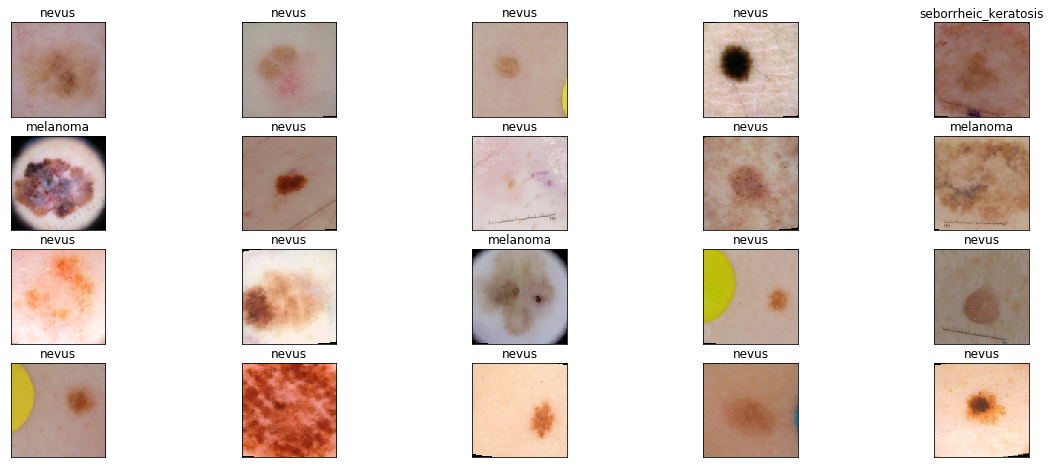

In [45]:

# Visualize some sample data

# helper function to :
# .. un-normalize (!!!! caution : this step depends on normalization Transform done above !!!)
# .. and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    img_t = np.transpose(img, (1, 2, 0)) # get view from 3xWxH to WxHx3 shape
    plt.imshow(img_t)
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labelIndex = dataiter.next()
images = images.numpy() # convert images to numpy for display

print("first train set read, # images {}, # labels {} ".format(len(images), len(labelIndex)))
print("shaped batch images {}, # shaped labels {} ".format(images.shape,labelIndex.shape))

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])    
    ax.set_title( train_data.classes[labelIndex[idx]] )


In [50]:
# define then Train & test my own classifier

import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # VA : it appears to have 133 classe of dogs in the database, 
        #      so our last linear layer will have 133 outputs 
        # 
        self.use_batch_normalization = True
        outClassesNum = 3 # 3 type of cancer to classify 
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # that padding allow keeping same res in/out "img"
        # VA : after conv1 step, "feat. imgs" depth is 8
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # that padding allow keeping same res in/out "img"
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1) # that padding allow keeping same res in/out "img"
        # Final Linear layers (fully connected)
        if self.use_batch_normalization:
            #self.linear1 = nn.Linear(32*16*16, 512, bias=False) # input feat. = d*k*k
            #self.batch_norm1 = nn.BatchNorm1d(512)
            self.linear1 = nn.Linear(32*16*16, 256, bias=False) # input feat. = d*k*k
            self.batch_norm1 = nn.BatchNorm1d(256)
        else:
            #self.linear1 = nn.Linear(32*16*16, 512) # input feat. = d*k*k
            self.linear1 = nn.Linear(32*16*16, 256) # input feat. = d*k*k
        if self.use_batch_normalization:
            #self.linear2 = nn.Linear(512, 256, bias=False)
            #self.batch_norm2 = nn.BatchNorm1d(256)
            self.linear2 = nn.Linear(256, 128, bias=False)
            self.batch_norm2 = nn.BatchNorm1d(128)
        else:
            #self.linear2 = nn.Linear(512, 256)
            self.linear2 = nn.Linear(256, 128)
        #self.linear3 = nn.Linear(256, outClassesNum) # final outpout = number of classes to separate
        self.linear3 = nn.Linear(128, outClassesNum) # final outpout = number of classes to separate
        # also define a max pooling layer for conv. Layers
        self.pool = nn.MaxPool2d(2, 2)
        # also define a droput method to help avoiding overfitting during training
        self.dropout = nn.Dropout(0.50) # 1D dropout, 50%

    
    def forward(self, x):
        ## Define forward behavior
        # 
        x = self.pool(F.relu(self.conv1(x))) # conv1 gives 128x128 x16 (depth)
        # VA note: after conv1 step plus pool, "feat. imgs" are 64x64 x16 (depth)
        x = self.pool(F.relu(self.conv2(x))) # conv2 gives 64x64 x32 (depth)
        # VA note: after conv2 step plus pool, "feat. imgs" are 32x32 x32 (depth)
        x = self.pool(F.relu(self.conv3(x))) # conv3 gives 32x32 x32 (depth)
        # VA note: after conv3 step plus pool, "feat. imgs" are 16x16 x32 (depth)
        # prep. for final fully connected layers :
        x = x.view(-1, 32 * 16*16) # view features as vector
        # use fully connected Linear layers
        # first one :
        x = self.linear1(x)
        if self.use_batch_normalization:
            x = self.batch_norm1(x)
        x = F.relu(x)
        # add a first dropout step to avoid overfitting
        x = self.dropout(x)
        # 2nd one :
        x = self.linear2(x)
        if self.use_batch_normalization:
            x = self.batch_norm2(x)
        x = F.relu(x)
        # add again a dropout step to avoid overfitting
        x = self.dropout(x)
        x= self.linear3(x) # now we should have a 3 classes PROBA. compat. network
        return x


In [51]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

# instantiate the CNN
model_cancer = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_cancer.cuda()

In [52]:
import torch.optim as optim

### TODO: select loss function
criterion_cancer = nn.CrossEntropyLoss() # None

### TODO: select optimizer
optimizer_cancer = optim.SGD(model_cancer.parameters(), lr=0.0015)#lr=0.001) #None
#optimizer_cancer = optim.Adam(model_cancer.parameters())

In [53]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            # VA :
            #print("batch_idx:{}, data_size(0):{}, target_size(0):{}".format(batch_idx, data.size(0), target.size(0)))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # VA :
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        # 
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model


# train the model 
model_scratch = train(15, data_loader_dic, model_cancer, optimizer_cancer, 
                      criterion_cancer, use_cuda, 'model_cancer.pt')

Epoch: 1 	Training Loss: 0.934808 	Validation Loss: 1.033965
Validation loss decreased (inf --> 1.033965).  Saving model ...
Epoch: 2 	Training Loss: 0.874348 	Validation Loss: 1.034325
Epoch: 3 	Training Loss: 0.845681 	Validation Loss: 0.982236
Validation loss decreased (1.033965 --> 0.982236).  Saving model ...
Epoch: 4 	Training Loss: 0.822038 	Validation Loss: 1.059093
Epoch: 5 	Training Loss: 0.808218 	Validation Loss: 0.984226
Epoch: 6 	Training Loss: 0.806399 	Validation Loss: 0.995035
Epoch: 7 	Training Loss: 0.809863 	Validation Loss: 1.049459
Epoch: 8 	Training Loss: 0.783586 	Validation Loss: 0.949585
Validation loss decreased (0.982236 --> 0.949585).  Saving model ...
Epoch: 9 	Training Loss: 0.787006 	Validation Loss: 1.010400
Epoch: 10 	Training Loss: 0.783682 	Validation Loss: 0.942283
Validation loss decreased (0.949585 --> 0.942283).  Saving model ...
Epoch: 11 	Training Loss: 0.773002 	Validation Loss: 0.933340
Validation loss decreased (0.942283 --> 0.933340).  Savi

In [54]:
# load the model that got the best validation accuracy
model_cancer.load_state_dict(torch.load('model_cancer.pt'))

<All keys matched successfully>

In [55]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(data_loader_dic, model_cancer, criterion_cancer, use_cuda)

Test Loss: 0.865279


Test Accuracy: 64% (388/600)


In [75]:
# test a specific image, display the 3 classes belong proba, the return most probale class

# the following import is required to be robust to truncated images
from PIL import Image
Image.LOAD_TRUNCATED_IMAGES = True

def predict_class_type(img_path):
    # load the image and return the predicted class
    
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    image = Image.open(img_path).convert('RGB')
    # let's resize img to fit model used size
    imgResize = 136
    imgSize = 128 # same size then while trainning CNN
    #size = 128 # same size then while trainning CNN
    in_transform = transforms.Compose([
                        transforms.Resize(imgResize),
                        transforms.CenterCrop(imgSize), 
                        #transforms.Resize((imgSize, imgSize)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
                        ]) # last normalisation
    # we should have a normalized, 3 color-planes, 128 px image
    
    image = in_transform(image).unsqueeze(0)  # need unsqueeze as only one image loaded (not a batch), to add 1 dim
    
    # move it to gpu if needed
    if use_cuda:
        image = image.cuda()
    # get the prediction from the trained model
    model_cancer.eval()
    class_pred = model_cancer(image)
    
    # class pred. should be an array with 3 (skin disease type) classes values here, 
    
    # back to cpu ?
    if use_cuda:
        class_pred = class_pred.cpu()
    
    #print("Classes pred shape:{} and data:{}".format(class_pred.shape, class_pred.data))
    
    # convert output probabilities to predicted class
    #    pred = output.data.max(1, keepdim=True)[1]
    # we will return the highest one
    
    val, idx = torch.max(class_pred, 1)
    # VA: get output back as proba
    sm =torch.nn.Softmax(dim=1) #torch.nn.Softmax(dim=None)
    classesProba = sm(class_pred) 
    #print("class.val:{}, -> class.idx = {} , all classes proba :{}".format(class_pred, idx, classesProba)) #torch.nn.Softmax(dim=None)
        
    
    pred_disease_class = train_data.classes[idx]
    #print("class. predic. values:{} , max.Prob.Class.Idx:{}, named:{}".format(val, idx, pred_disease_class))
    
    return  pred_disease_class, idx, classesProba # return pred_class, its index, and ALL classes proba

In [76]:
def show_image(img_path):
    # load color (BGR) image
    img = cv2.imread(img_path)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # display the image
    plt.imshow(cv_rgb)
    plt.show()

def handle_query_image(img_path):
    show_image(img_path)
    # what this image is closest to in term of skin disease ?
    pred_class, pred_class_idx, classesProba = predict_class_type(img_path)
    print("Closest skin disease classe is : {}\n".format(pred_class))
 
def run_app(img_path):
    print("- Processing : {} -".format(img_path))
    ## submit image query (+ display)
    handle_query_image(img_path)
    print("--------------------------------")


Will test some of the 42 image(s) from folder data\extra/
- Processing : data\extra\melanoma\ISIC_0000002.jpg -


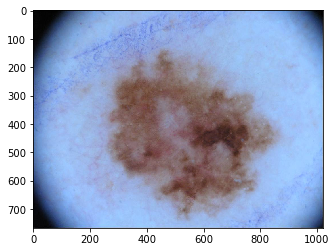

Closest skin disease classe is : melanoma

--------------------------------
- Processing : data\extra\melanoma\ISIC_0000004.jpg -


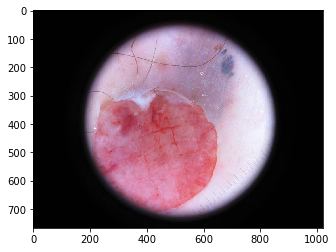

Closest skin disease classe is : melanoma

--------------------------------
- Processing : data\extra\melanoma\ISIC_0000013.jpg -


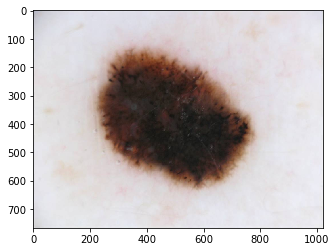

Closest skin disease classe is : nevus

--------------------------------
- Processing : data\extra\melanoma\ISIC_0000022.jpg -


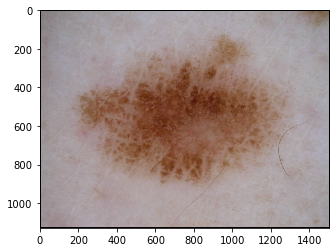

Closest skin disease classe is : nevus

--------------------------------
- Processing : data\extra\melanoma\ISIC_0000026.jpg -


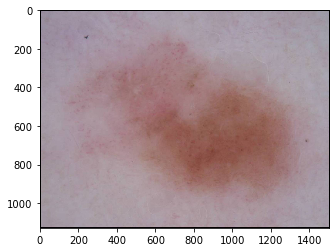

Closest skin disease classe is : nevus

--------------------------------
- Processing : data\extra\melanoma\ISIC_0000029.jpg -


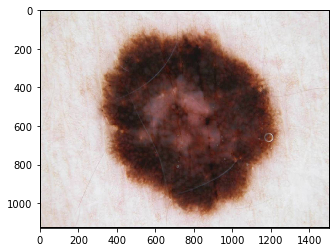

Closest skin disease classe is : melanoma

--------------------------------
- Processing : data\extra\nevus\ISIC_0000000.jpg -


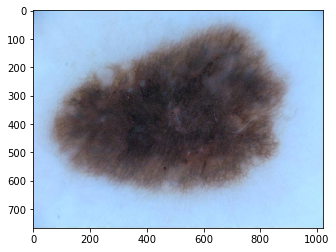

Closest skin disease classe is : melanoma

--------------------------------
- Processing : data\extra\nevus\ISIC_0000001.jpg -


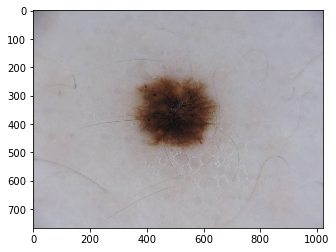

Closest skin disease classe is : nevus

--------------------------------
- Processing : data\extra\nevus\ISIC_0000003.jpg -


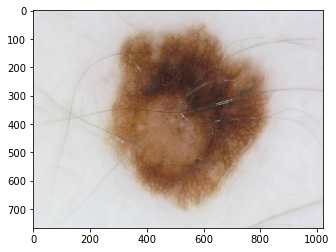

Closest skin disease classe is : nevus

--------------------------------


In [91]:
from glob import glob

# i copied 3x3 copied images, each 3 from test/train/valid set :

extraDataPath = os.path.join(rootDataDir, 'extra/')# on local repo
#extraDataPath = os.path.join(rootDataDir+'/test/', 'melanoma/')# on local repo

# load filenames for human and dog images
some_images_files = np.array(glob(extraDataPath+"/*/*")) #np.array(glob("lfw/*/*"))
#some_images_files = np.array(glob(extraDataPath+"/*"))

print("Will test some of the {} image(s) from folder {}".format(len(some_images_files), extraDataPath))


for file in some_images_files[:9]:
    run_app(file)



In [ ]:
# now prepare exportation into csv file of the predicted classification for the TEST images

In [98]:
from glob import glob

    
#    
# we'll process ALL the test images (600 images, splitted in 3 folders) :
#

def getBiTaskProbas(testFileName):
    pred_class, pred_class_idx, classesProba = predict_class_type(testFileName)
    # pass from [[xxx, yyy, zzz]] to [xxx, yyy, zzz] , then from tensor to numpy array
    classes_probs = classesProba.data.numpy().squeeze() #np.asarray(classes_probas.squeeze())
    #print("- Predict. image: {}, \n ,closest classe: {} , overall probas:{} of type:{}\n".format(testFileName, pred_class, classes_probs, type(classesProba) ))
    return classes_probs[0], classes_probs[2]
    

testDataPath = os.path.join(rootDataDir, 'test/')# on local repo

# load filenames for human and dog images
test_images_files = np.array(glob(testDataPath+"/*/*")) #np.array(glob("lfw/*/*"))

nbImages = len(test_images_files)

print("Will test some of the {} image(s) from folder {}: \n".format(nbImages, testDataPath))

#np.savetxt('np.csv', a, fmt='%.2f', delimiter=',', header=" #1,  #2,  #3,  #4")

# on the 3 predictables classes, we output 2 on 3 proba, as we may retrieve the 3thrd easilt
# so we ouput Task_1 being 'melanoma', and Task_2 being 'seborrheic_keratosis'

outPredArray = np.ndarray(shape=(nbImages, 3), dtype='object')

for fileIdx in range(0, nbImages):
    testFileName = test_images_files[fileIdx]
    tk1_proba, tk2_proba = getBiTaskProbas(testFileName)
    outPredArray[fileIdx,0] = testFileName
    outPredArray[fileIdx,1] = tk1_proba
    outPredArray[fileIdx,2] = tk2_proba

# save file
np.savetxt('sample_predictions_VA.csv', outPredArray, fmt='%s',delimiter=',', header="Id,task_1,task_2", comments='' )


Will test some of the 600 image(s) from folder data\test/: 

